In [1]:
import pandas as pd

import numpy as np

from scipy.signal import welch

from scipy.stats import skew, kurtosis

from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

import seaborn as sns

In [2]:
df = pd.read_csv('../datasets/final/imu_data_filtered.csv')

In [3]:
df.head()

filtered accelerometer      gyro  surface
0                0.028466  1.698736  asphalt
1               -0.042912  2.051725  asphalt
2                0.280607  0.895211  asphalt
3                0.224717  1.276459  asphalt
4                0.047872  4.475666  asphalt

In [4]:
def sliding_window(df, window_size):
    
    groups = []
    
    current_group = []
    
    current_surface = None  

    for index, row in df.iterrows():
        
        if current_surface is None:
            
            current_surface = row['surface']  

        if row['surface'] == current_surface:
            
            current_group.append((row['filtered accelerometer'], row['gyro']))

            if len(current_group) == window_size:
                
                groups.append((current_group, current_surface)) 
                
                current_group = [] 

        else:
            
            if len(current_group) == window_size:
                
                groups.append((current_group, current_surface))

            current_group = [(row['filtered accelerometer'], row['gyro'])]
            
            current_surface = row['surface']
            
    if len(current_group) == window_size:
        
        groups.append((current_group, current_surface))

    return groups

In [5]:
def calculate_mean(data):
    
    accelerometer_mean = np.mean([x[0] for x in data[0]])
    
    gyro_mean = np.mean([x[1] for x in data[0]])
    
    return accelerometer_mean, gyro_mean

def calculate_std(data):
    
    accelerometer_std = np.std([x[0] for x in data[0]])  
    
    gyro_std = np.std([x[1] for x in data[0]]) 
    
    return accelerometer_std, gyro_std

def calculate_max(data):
    
    accelerometer_max = np.max([x[0] for x in data[0]]) 
    
    gyro_max = np.max([x[1] for x in data[0]])  
    
    return accelerometer_max, gyro_max

def calculate_min(data):
    
    accelerometer_min = np.min([x[0] for x in data[0]]) 
    
    gyro_min = np.min([x[1] for x in data[0]]) 
    
    return accelerometer_min, gyro_min

def calculate_iqr(data):
    
    accelerometer_iqr = np.percentile([x[0] for x in data[0]], 75) - np.percentile([x[0] for x in data[0]], 25)
    
    gyro_iqr = np.percentile([x[1] for x in data[0]], 75) - np.percentile([x[1] for x in data[0]], 25)
    
    return accelerometer_iqr, gyro_iqr

def calculate_skewness(data):
    
    accelerometer_skew = skew([x[0] for x in data[0]])
    
    gyro_skew = skew([x[1] for x in data[0]])
    
    return accelerometer_skew, gyro_skew

def calculate_kurtosis(data):
    
    accelerometer_kurt = kurtosis([x[0] for x in data[0]])
    
    gyro_kurt = kurtosis([x[1] for x in data[0]])
    
    return accelerometer_kurt, gyro_kurt
    
def calculate_fft_peak(data):
    
    fft_acc = np.fft.fft([x[0] for x in data[0]])
    
    fft_gyro = np.fft.fft([x[1] for x in data[0]])
    
    mag_acc = np.abs(fft_acc)
    
    mag_gyro = np.abs(fft_gyro)
    
    peak_index_acc = np.argmax(mag_acc)
    
    peak_index_gyro = np.argmax(mag_gyro)
    
    peak_amplitude_acc = mag_acc[peak_index_acc]
    
    peak_amplitude_gyro = mag_gyro[peak_index_gyro]
    
    return peak_amplitude_acc, peak_amplitude_gyro

def calculate_psd(data):
    
    accelerometer_data = np.array([x[0] for x in data[0]])
    
    gyro_data = np.array([x[1] for x in data[0]])

    f_acc, psd_acc = welch(accelerometer_data, fs=100, nperseg=100)  
    
    f_gyro, psd_gyro = welch(gyro_data, fs=100, nperseg=100)  

    peak_freq_acc = f_acc[np.argmax(psd_acc)]
    
    peak_power_acc = np.max(psd_acc)
    
    peak_freq_gyro = f_gyro[np.argmax(psd_gyro)]
    
    peak_power_gyro = np.max(psd_gyro)

    return peak_freq_acc, peak_power_acc, peak_freq_gyro, peak_power_gyro

def extract_surface(data):

    surface = data[1]

    return surface

In [6]:
def extract_features(segments):
    
    features_list = []
    
    for segment in segments:

        psd_features = calculate_psd(segment)
        
        features = {
            'accelerometer_mean': calculate_mean(segment)[0],
            'gyro_mean': calculate_mean(segment)[1],
            'accelerometer_std': calculate_std(segment)[0],
            'gyro_std': calculate_std(segment)[1],
            'accelerometer_max': calculate_max(segment)[0],
            'gyro_max': calculate_max(segment)[1],
            'accelerometer_min': calculate_min(segment)[0],
            'gyro_min': calculate_min(segment)[1],
            'accelerometer_iqr': calculate_iqr(segment)[0],
            'gyro_iqr': calculate_iqr(segment)[1],
            'accelerometer_skewness': calculate_skewness(segment)[0],
            'gyro_skewness': calculate_skewness(segment)[1],
            'accelerometer_kurtosis': calculate_kurtosis(segment)[0],
            'gyro_kurtosis': calculate_kurtosis(segment)[1],
            'accelerometer_fft_peak_amplitude': calculate_fft_peak(segment)[0],
            'gyro_fft_peak_amplitude': calculate_fft_peak(segment)[1],
            'accelerometer_peak_freq': psd_features[0],
            'accelerometer_peak_power': psd_features[1],
            'gyro_peak_freq': psd_features[2],
            'gyro_peak_power': psd_features[3],
            'surface': extract_surface(segment)
        }
        features_list.append(features)
    
    return features_list

In [7]:
window_data_list = sliding_window(df, 800)

features_list = extract_features(window_data_list)

In [8]:
df3 = pd.DataFrame(features_list)

df3

accelerometer_mean  gyro_mean  accelerometer_std  gyro_std  \
0             0.011494   4.088094           0.150098  1.715527   
1            -0.000389   4.110244           0.151880  2.026555   
2             0.000009   4.985285           0.163144  2.036402   
3             0.000436   4.937461           0.184042  2.435101   
4            -0.000730   5.868163           0.145933  2.851125   
..                 ...        ...                ...       ...   
82           -0.000151   1.937606           0.046901  0.830457   
83           -0.000021   2.795290           0.049054  1.721389   
84            0.000047   2.052887           0.050346  1.172562   
85            0.000147   2.328377           0.045882  1.127532   
86           -0.000038   1.814298           0.042030  0.814065   

    accelerometer_max   gyro_max  accelerometer_min  gyro_min  \
0            0.644196   9.956556          -0.473554  0.316045   
1            0.544672  15.012360          -0.535466  0.364618   
2            0.544369  13.532635          -0.556234  0.630060   
3            0.900636  16.030110          -0.620048  0.470308   
4            0.441736  17.694543          -0.507420  0.177947   
..                ...        ...                ...       ...   
82           0.176415   4.317941          -0.206634  0.074753   
83           0.152992   9.076928          -0.155672  0.264290   
84           0.154776   6.363829          -0.181214  0.244617   
85           0.184846   7.274506          -0.152204  0.151054   
86           0.145971   5.047201          -0.167614  0.098888   

    accelerometer_iqr  gyro_iqr  ...  gyro_skewness  accelerometer_kurtosis  \
0            0.186426  2.294426  ...       0.468403                0.854220   
1            0.191129  3.014037  ...       0.678789                0.508161   
2            0.206182  2.827237  ...       0.532433                0.202361   
3            0.216181  3.136322  ...       0.909298                1.298256   
4            0.194253  4.062648  ...       0.634848                0.056581   
..                ...       ...  ...            ...                     ...   
82           0.058712  1.166162  ...       0.302273                1.218602   
83           0.062303  2.065414  ...       1.072850                0.041913   
84           0.063368  1.346721  ...       1.158737                0.279118   
85           0.059154  1.452775  ...       0.819679                0.303469   
86           0.054815  1.085840  ...       0.613422                0.521150   

    gyro_kurtosis  accelerometer_fft_peak_amplitude  gyro_fft_peak_amplitude  \
0        0.007515                         13.760962              3270.475431   
1        0.584581                         12.547145              3288.195284   
2        0.264237                         19.744590              3988.228076   
3        1.331257                         17.355331              3949.969015   
4        0.008948                         11.777489              4694.530117   
..            ...                               ...                      ...   
82      -0.406048                          3.569404              1550.084833   
83       0.504903                          4.210110              2236.232382   
84       1.135411                          4.782657              1642.309770   
85       1.176091                          3.894108              1862.701529   
86       0.218491                          3.599608              1451.438155   

    accelerometer_peak_freq  accelerometer_peak_power  gyro_peak_freq  \
0                      29.0                  0.001442             1.0   
1                      28.0                  0.001182             1.0   
2                      27.0                  0.001994             1.0   
3                      20.0                  0.002033             1.0   
4                      26.0                  0.001100             1.0   
..                      ...                       ...             ...   
82       

In [10]:
window_size_list = range(100, 600, 100)

kernel_list = ['linear', 'rbf', 'sigmoid']

In [11]:
encoder = OrdinalEncoder()

scaler = StandardScaler()

just_some_list = []

for i in window_size_list:

    window_data_list = sliding_window(df, i)

    features_list = extract_features(window_data_list)

    features_df = pd.DataFrame(features_list)

    features_df['surface_encoded'] = encoder.fit_transform(features_df[['surface']])

    features_df = features_df.drop('surface', axis = 1)

    X = features_df.drop('surface_encoded', axis = 1)

    y = features_df['surface_encoded']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

    X_train_scaled = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    for j in kernel_list:
        
        svm_classifier = SVC(kernel = j)

        svm_classifier.fit(X_train_scaled, y_train)

        y_pred = svm_classifier.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)

        f1 = f1_score(y_test, y_pred, average='weighted')

        new_list = {

            'window size': i,

            'kernel' : j,

            'accuracy' : accuracy,

            'f-score' : f1

        }

        just_some_list.append(new_list) 

In [12]:
df2 = pd.DataFrame(just_some_list)

In [13]:
df2[df2['window size'] == 1000]

Empty DataFrame
Columns: [window size, kernel, accuracy, f-score]
Index: []

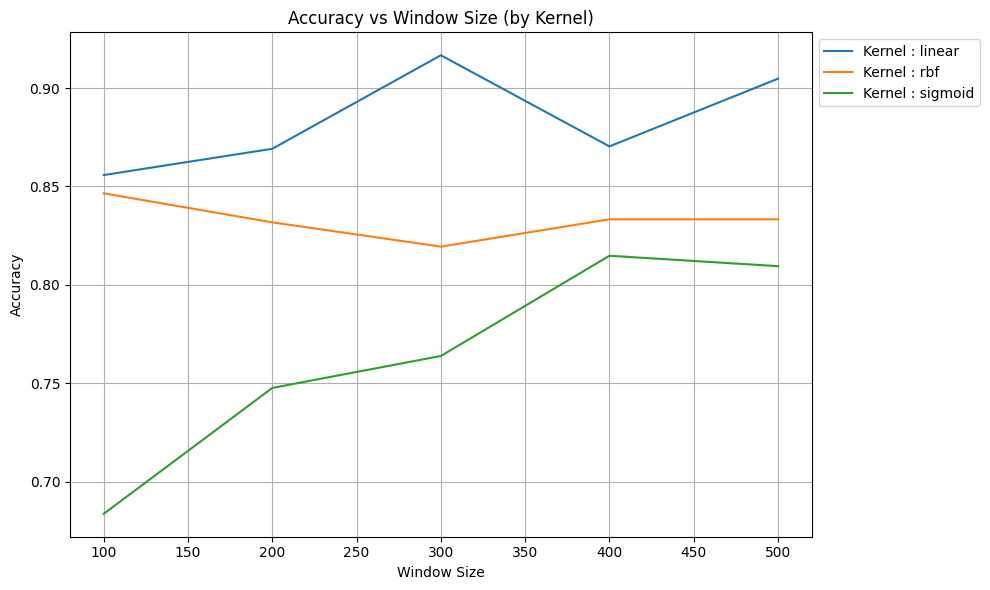

In [14]:
unique_kernels = df2['kernel'].unique()

plt.figure(figsize = (10,6))

for i in unique_kernels:

    kernel_data = df2[df2['kernel'] == i]

    window_size = kernel_data['window size']

    accuracy = kernel_data['accuracy']

    plt.plot(window_size, accuracy, label = f'Kernel : {i}')

plt.xlabel('Window Size')

plt.ylabel('Accuracy')

plt.title('Accuracy vs Window Size (by Kernel)')

plt.legend(bbox_to_anchor=(1.0, 1.0), loc = 'upper left')

plt.grid(True)

plt.tight_layout()

plt.show()

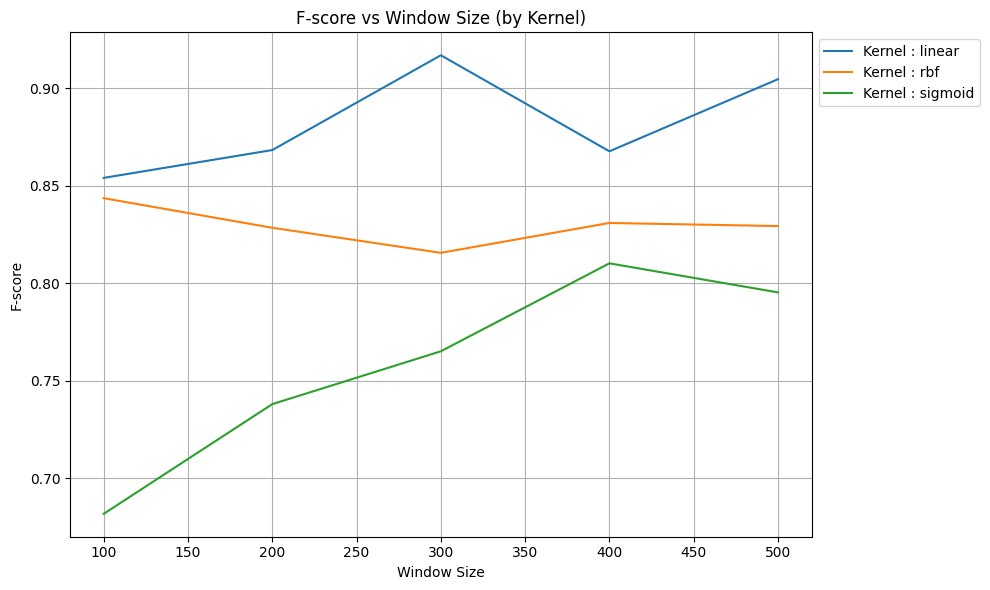

In [15]:
unique_kernels = df2['kernel'].unique()

plt.figure(figsize = (10,6))

for i in unique_kernels:

    kernel_data = df2[df2['kernel'] == i]

    window_size = kernel_data['window size']

    f_score = kernel_data['f-score']

    plt.plot(window_size, f_score, label = f'Kernel : {i}')

plt.xlabel('Window Size')

plt.ylabel('F-score')

plt.title('F-score vs Window Size (by Kernel)')

plt.legend(bbox_to_anchor=(1.0, 1.0), loc = 'upper left')

plt.grid(True)

plt.tight_layout()

plt.show()

In [16]:
window_data_list = sliding_window(df, 300)

features_list = extract_features(window_data_list)

In [17]:
features_df = pd.DataFrame(features_list)

In [18]:
features_df.head()

accelerometer_mean  gyro_mean  accelerometer_std  gyro_std  \
0            0.029646   3.853323           0.126777  1.528142   
1           -0.000137   4.043789           0.151452  1.853173   
2            0.000222   4.236653           0.165477  1.871945   
3           -0.000241   3.719515           0.166111  1.989475   
4            0.000237   4.535716           0.146751  2.012017   

   accelerometer_max   gyro_max  accelerometer_min  gyro_min  \
0           0.514575   8.767034          -0.349825  0.600545   
1           0.430898   9.563268          -0.473554  0.316045   
2           0.644196  10.470187          -0.442172  0.455980   
3           0.485615  15.012360          -0.473653  0.364618   
4           0.487013  10.474311          -0.535466  0.540773   

   accelerometer_iqr  gyro_iqr  ...  gyro_skewness  accelerometer_kurtosis  \
0           0.158270  2.001158  ...       0.452022                0.488582   
1           0.190476  2.390419  ...       0.581666                0.793256   
2           0.200487  2.611616  ...       0.474852                0.883874   
3           0.234392  2.487469  ...       1.297452               -0.104563   
4           0.171526  3.158394  ...       0.166528                1.014571   

   gyro_kurtosis  accelerometer_fft_peak_amplitude  gyro_fft_peak_amplitude  \
0      -0.040627                          8.893948              1155.996925   
1      -0.073373                          9.786324              1213.136813   
2       0.121367                          8.096234              1270.995778   
3       3.226102                          8.877086              1115.854353   
4      -0.584376                          6.439084              1360.714855   

   accelerometer_peak_freq  accelerometer_peak_power  gyro_peak_freq  \
0                     28.0                  0.001004             2.0   
1                     22.0                  0.001879             1.0   
2                     30.0                  0.001787             3.0   
3                     27.0                  0.001691             1.0   
4                     33.0                  0.001046             1.0   

   gyro_peak_power  surface  
0         0.293793  asphalt  
1         0.739390  asphalt  
2         0.305698  asphalt  
3         0.434840  asphalt  
4         0.981400  asphalt  

[5 rows x 21 columns]

In [19]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

features_df['surface_encoded'] = encoder.fit_transform(features_df[['surface']])

In [20]:
features_df.head()

accelerometer_mean  gyro_mean  accelerometer_std  gyro_std  \
0            0.029646   3.853323           0.126777  1.528142   
1           -0.000137   4.043789           0.151452  1.853173   
2            0.000222   4.236653           0.165477  1.871945   
3           -0.000241   3.719515           0.166111  1.989475   
4            0.000237   4.535716           0.146751  2.012017   

   accelerometer_max   gyro_max  accelerometer_min  gyro_min  \
0           0.514575   8.767034          -0.349825  0.600545   
1           0.430898   9.563268          -0.473554  0.316045   
2           0.644196  10.470187          -0.442172  0.455980   
3           0.485615  15.012360          -0.473653  0.364618   
4           0.487013  10.474311          -0.535466  0.540773   

   accelerometer_iqr  gyro_iqr  ...  accelerometer_kurtosis  gyro_kurtosis  \
0           0.158270  2.001158  ...                0.488582      -0.040627   
1           0.190476  2.390419  ...                0.793256      -0.073373   
2           0.200487  2.611616  ...                0.883874       0.121367   
3           0.234392  2.487469  ...               -0.104563       3.226102   
4           0.171526  3.158394  ...                1.014571      -0.584376   

   accelerometer_fft_peak_amplitude  gyro_fft_peak_amplitude  \
0                          8.893948              1155.996925   
1                          9.786324              1213.136813   
2                          8.096234              1270.995778   
3                          8.877086              1115.854353   
4                          6.439084              1360.714855   

   accelerometer_peak_freq  accelerometer_peak_power  gyro_peak_freq  \
0                     28.0                  0.001004             2.0   
1                     22.0                  0.001879             1.0   
2                     30.0                  0.001787             3.0   
3                     27.0                  0.001691             1.0   
4                     33.0                  0.001046             1.0   

   gyro_peak_power  surface  surface_encoded  
0         0.293793  asphalt              0.0  
1         0.739390  asphalt              0.0  
2         0.305698  asphalt              0.0  
3         0.434840  asphalt              0.0  
4         0.981400  asphalt              0.0  

[5 rows x 22 columns]

In [21]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   accelerometer_mean                237 non-null    float64
 1   gyro_mean                         237 non-null    float64
 2   accelerometer_std                 237 non-null    float64
 3   gyro_std                          237 non-null    float64
 4   accelerometer_max                 237 non-null    float64
 5   gyro_max                          237 non-null    float64
 6   accelerometer_min                 237 non-null    float64
 7   gyro_min                          237 non-null    float64
 8   accelerometer_iqr                 237 non-null    float64
 9   gyro_iqr                          237 non-null    float64
 10  accelerometer_skewness            237 non-null    float64
 11  gyro_skewness                     237 non-null    float64
 12  accelero

In [22]:
features_df = features_df.drop('surface', axis = 1)

In [23]:
X = features_df.drop('surface_encoded', axis = 1)

Y = features_df['surface_encoded']

In [24]:
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42, stratify = Y)

In [25]:
scaler = StandardScaler()

In [26]:
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [27]:
svm_classifier = SVC(kernel='linear')

In [28]:
svm_classifier.fit(X_train_scaled, Y_train)

SVC(kernel='linear')

In [29]:
y_pred = svm_classifier.predict(X_test_scaled)

In [30]:
accuracy = accuracy_score(Y_test, y_pred)

In [31]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.9166666666666666


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(Y_test, y_pred, average='weighted')

recall = recall_score(Y_test, y_pred, average='weighted')

f1 = f1_score(Y_test, y_pred, average='weighted')

In [33]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9186590608465609
Recall: 0.9166666666666666
F1 Score: 0.9168171539479165


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

print("Confusion Matrix:")

print(cm)

Confusion Matrix:
[[39  6  0  0  0]
 [16 26  0  0  2]
 [ 0  0 39  1  0]
 [ 1  0  2 45  1]
 [ 1  1  0  0 35]]


In [34]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# Assuming X and Y have been defined already, where Y is the target variable with class labels

# Define the cross-validator with stratification
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline that first scales the data and then applies the SVM classifier
pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Perform cross-validation using StratifiedKFold
cv_scores = cross_val_score(pipeline, X, Y, cv=stratified_k_fold)

# Print the accuracy for each fold
for i, score in enumerate(cv_scores, 1):
    print(f"Accuracy for fold {i}: {score:.4f}")

# Print the mean accuracy across all folds, if needed
print("Mean CV accuracy:", cv_scores.mean())


Accuracy for fold 1: 0.8542
Accuracy for fold 2: 0.8958
Accuracy for fold 3: 0.8723
Accuracy for fold 4: 0.9574
Accuracy for fold 5: 0.9574
Mean CV accuracy: 0.9074468085106384


In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 

X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)

In [39]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_pca, Y_train)


SVC(kernel='linear', random_state=42)

In [40]:
y_pred = svm_classifier.predict(X_test_pca)

ValueError: X has 9 features, but SVC is expecting 20 features as input.

In [41]:
X_test_scaled

array([[-2.89524974e-01,  2.86587687e+00, -1.19026914e+00, ...,
        -4.43364557e-01, -5.45478505e-01,  3.24824536e+00],
       [-4.15733162e-02, -9.75627293e-01, -4.99165551e-01, ...,
        -3.19303115e-01, -5.45478505e-01, -3.26672240e-01],
       [-1.68284404e-01,  4.39912651e-01, -2.81937369e-01, ...,
        -2.43729648e-01, -5.45478505e-01, -4.58578979e-02],
       ...,
       [ 8.63313614e-04, -9.39712387e-01, -1.25936213e+00, ...,
        -5.06553232e-01, -5.45478505e-01, -3.15710231e-01],
       [-6.90406337e-01,  2.59121390e+00, -1.71018266e-02, ...,
        -7.67384115e-02, -5.45478505e-01,  2.99083236e+00],
       [ 2.65938782e-01, -5.20205615e-01,  4.58133413e-01, ...,
        -1.46596657e-01,  2.17266862e-01, -2.96656993e-01]])